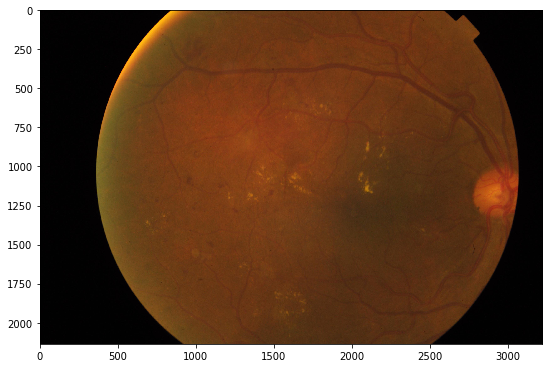

In [29]:
import os
import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as utils

import imgaug as ia
from imgaug import augmenters as iaa

BATCH_SIZE = 4

datapath = 'd:/dataset/aptos2019-blindness-detection/train_images/'
labelpath = 'd:/dataset/aptos2019-blindness-detection/train.csv'
files = glob.glob(datapath + '*.png')

img = cv2.imread(files[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(9,16))
plt.imshow(img)
plt.show()

0 torch.Size([4, 3, 256, 256]) torch.Size([4])
1 torch.Size([4, 3, 256, 256]) torch.Size([4])
2 torch.Size([4, 3, 256, 256]) torch.Size([4])
3 torch.Size([4, 3, 256, 256]) torch.Size([4])


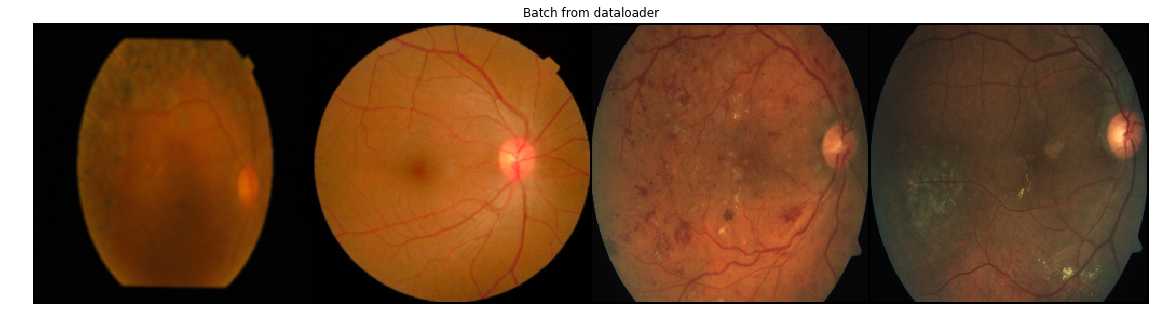

In [33]:
class AptosDataset(object):
    """
        input : data folder path
        output : train, test, validation set
        [numpy array with mini batch]
        method : None
    """

    def __init__(self, d_path='./', label_file='./', preprocess=False, transform=None):
        super(AptosDataset, self).__init__()

        self.data_path = d_path
        self.image_list = os.listdir(d_path)
        self.train_csv = pd.read_csv(label_file)
        self.preprocess = preprocess
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):

        # read image
        image_name = self.image_list[index]
        img_id = image_name.rstrip('.png')

        image = self.read_image(os.path.join(self.data_path, image_name))
        
        if self.preprocess:
#             image = preprocessing(image)
            pass

        image = self.resize(image)
        if len(image.shape) != 3:
            image = self.expand_channel(image)

        # get labels
        label = self.read_label(img_id)
        
        # Augmentation (transformation)
        if self.transform:
            image = self.transform(image)
        
        # to Tensor
        image = self.ToTensor(image)
        sample = {'image' : image, 'label' : label}

        return sample
    
    
    def resize(self, image, target_shape=(256, 256)):
        # 299 is fixed size of inception v3 network
        resized_image = cv2.resize(image, target_shape, interpolation = cv2.INTER_CUBIC)
        return resized_image

    def expand_channel(self, image):
        # merges single channel image to 3 channel image ( all same images )
        expanded_image = cv2.merge((image, image, image))
        return expanded_image

    def read_label(self, img_id):
#         return int(self.train_csv[self.train_csv['id_code'] == img_id]['diagnosis'])
        return 0

    def read_image(self, image_name):
        img = cv2.imread(image_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img

    def ToTensor(self, image):
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return torch.from_numpy(image)


class ImgAugTransform():
    def __init__(self, gaussian_blur_sigma=1.5, probability=0.2):
        self.sometimes = lambda aug: iaa.Sometimes(probability, aug)
        self.aug = iaa.Sequential([
            self.sometimes(
                iaa.GaussianBlur(sigma=(0, gaussian_blur_sigma))
            )
        ])    

    def __call__(self, image):
        image = np.array(image)
        image = self.aug.augment_image(image)
        return image
        
transform_train = transforms.Compose([
                                        # provided augmentation in transforms
#                                         transforms.Resize()
#                                         transforms.Grayscale()
#                                         transforms.Normalize()
#                                         transforms.LinearTransformation()
#                                         transforms.Scale()
#                                         transforms.RandomVerticalFlip()
#                                         transforms.RandomHorizontalFlip
                                        
                                        # custom augmentation
                                        ImgAugTransform()
                                       ])

traindataset = AptosDataset(datapath, labelpath, transform=transform_train)
train_loader = DataLoader(traindataset, batch_size=BATCH_SIZE, shuffle=True)


def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = sample_batched['image'], sample_batched['label']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched['image'].size(), sample_batched['label'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure(figsize=(20,20))
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break